# Applying tsfresh to the M5 Competition
#### Kartikey Vyas

This notebook applies automated feature extraction and selection to data from the M5 competition. The M5 Kaggle competition was the fifth iteration of the "Makidrakis" Competitions from the University of Nicosia. The aim of the competition was to forecast the next 28 days of sales for Walmart in the US. We are provided hierarchicial sales data, broken down at the item level, department, product category, store and state. Additionally, the data set has information on price, promotions and special events. This competition serves as a very close example of what we are trying to achieve with the RETAILER project at FORECASTING_STARTUP.

An algorithm termed Feature Extraction based on Scalable Hypothesis tests (FRESH), comprises comprehensive, automated feature extraction and selection. First, a comprehensive set of time series features are extracted through well-established mappings. Next, each feature is tested for its statistical significance and adjustments are made to account for the accumulation of statistical error. This process is used to select relevant features that can then form a feature matrix that acts as the input to a machine learning algorithm. This algorithm is described in a 2017 paper (shout-out Andreas) [[1]](#fresh).

![freshalgo](fresh_algo.png)

The FRESH algorithm is implemented in a Python-based machine learning library called tsfresh.

## Contents
1. [Data Manipulation](#dataset)
2. [Feature Extraction](#extraction)
3. [Feature Selection](#selection)
4. [Regression (Forecasting)](#reg)
5. [Classification](#class)
6. [References](#refs)

## Data Manipulation <a name="dataset"></a>

To recap, we are given **42,840** hierarchical time-series. There are 3049 individual products from 3 categories and 7 departments, sold in 10 stores in 3 states. The sales information covers Jan 2011 to June 2016. For the purposes of demonstrating `tsfresh`, we will use data from only one department in one store, considering just the last two years of data. `tsfresh` needs the time-series data in a very specific format before feature extraction can be conducted, so we will first transform the data.

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.feature_selection import select_features
from tsfresh.feature_selection.significance_tests import target_real_feature_binary_test, target_real_feature_real_test
from tsfresh.feature_selection.relevance import calculate_relevance_table

In [2]:
## READ DATA ######################################################################################
train = pd.read_csv('data/raw/sales_train_validation.csv')
prices = pd .read_csv('data/raw/sell_prices.csv')
calendar = pd.read_csv('data/raw/calendar.csv')

In [3]:
print(train.shape)
train.head(3)

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [4]:
print(calendar.shape)
calendar.head(3)

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [5]:
print(prices.shape)
prices.head(3)

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


The first step is to pull out just the time series from the data. We'll add the other variables into the design matrix later.

In [6]:
## PRE-PROCESSING #################################################################################
df_ts = (train[(train['store_id'] == 'WI_1') & \
               (train['dept_id'] == 'HOUSEHOLD_1')]
     .set_index('id')
     .iloc[:,5:]
     .T
     .iloc[-730:,:])

# add date as an index
calendar.index = calendar['d']
date_features = (calendar[calendar.index.isin(df_ts.index)]
                 .set_index('date'))
df_ts.index = date_features.index
print(df_ts.shape)
df_ts.head()

(730, 532)


id,HOUSEHOLD_1_001_WI_1_validation,HOUSEHOLD_1_002_WI_1_validation,HOUSEHOLD_1_003_WI_1_validation,HOUSEHOLD_1_004_WI_1_validation,HOUSEHOLD_1_005_WI_1_validation,HOUSEHOLD_1_006_WI_1_validation,HOUSEHOLD_1_007_WI_1_validation,HOUSEHOLD_1_008_WI_1_validation,HOUSEHOLD_1_009_WI_1_validation,HOUSEHOLD_1_010_WI_1_validation,...,HOUSEHOLD_1_532_WI_1_validation,HOUSEHOLD_1_533_WI_1_validation,HOUSEHOLD_1_534_WI_1_validation,HOUSEHOLD_1_535_WI_1_validation,HOUSEHOLD_1_536_WI_1_validation,HOUSEHOLD_1_537_WI_1_validation,HOUSEHOLD_1_538_WI_1_validation,HOUSEHOLD_1_539_WI_1_validation,HOUSEHOLD_1_540_WI_1_validation,HOUSEHOLD_1_541_WI_1_validation
date,,,,,,,,,,,,,,,,,,,,,
2014-04-26,1,7,1,0,3,0,1,0,0,0,...,0,1,0,5,7,1,6,4,4,0
2014-04-27,0,2,3,2,0,0,2,0,0,0,...,2,3,0,2,1,1,2,2,3,0
2014-04-28,0,3,1,2,1,2,0,0,0,0,...,1,3,0,0,0,1,0,1,1,0
2014-04-29,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,3,1,2,1,4,0
2014-04-30,0,4,1,0,0,0,2,0,0,0,...,1,1,0,4,2,2,2,3,4,0


In [7]:
cat_features = (train[(train['store_id'] == 'WI_1') & \
               (train['dept_id'] == 'HOUSEHOLD_1')]
     .iloc[:,:5]
     .rename(columns={'id':'prod_id'}))
cat_features.head()

,prod_id,item_id,dept_id,cat_id,store_id
21908,HOUSEHOLD_1_001_WI_1_validation,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,WI_1
21909,HOUSEHOLD_1_002_WI_1_validation,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,WI_1
21910,HOUSEHOLD_1_003_WI_1_validation,HOUSEHOLD_1_003,HOUSEHOLD_1,HOUSEHOLD,WI_1
21911,HOUSEHOLD_1_004_WI_1_validation,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,WI_1
21912,HOUSEHOLD_1_005_WI_1_validation,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,WI_1


In [8]:
# pivot to long format
df_melted = df_ts.copy()
df_melted['date'] = df_melted.index
df_melted = df_melted.melt(id_vars='date', value_name='sales')
df_melted.head()

,date,id,sales
0,2014-04-26,HOUSEHOLD_1_001_WI_1_validation,1
1,2014-04-27,HOUSEHOLD_1_001_WI_1_validation,0
2,2014-04-28,HOUSEHOLD_1_001_WI_1_validation,0
3,2014-04-29,HOUSEHOLD_1_001_WI_1_validation,1
4,2014-04-30,HOUSEHOLD_1_001_WI_1_validation,0


### Rolling Windows
tsfresh has a built-in function that can take a DataFrame of time series in a long format and produce rolling windows, upon which feature extraction can be conducted. **Warning** This process is quite CPU intensive.

In [12]:
# create rolling windows
df_rolled_ts = roll_time_series(df_melted, column_id='id', column_sort='date',
                            max_timeshift=28, min_timeshift=7)
df_rolled_ts.to_hdf('data/interim/rolled_ts_WI_1_HOUSEHOLD_1.h5', \
                    key='data', complevel=9)
df_rolled_ts.head()

,date,id,sales
0,2014-04-26,"(HOUSEHOLD_1_001_WI_1_validation, 2014-05-03)",1
1,2014-04-27,"(HOUSEHOLD_1_001_WI_1_validation, 2014-05-03)",0
2,2014-04-28,"(HOUSEHOLD_1_001_WI_1_validation, 2014-05-03)",0
3,2014-04-29,"(HOUSEHOLD_1_001_WI_1_validation, 2014-05-03)",1
4,2014-04-30,"(HOUSEHOLD_1_001_WI_1_validation, 2014-05-03)",0


### Feature Extraction <a name="extraction"></a>
Feature extraction in tsfresh computes a total of 794 time series features based on 63 time series characterisation methods. See all the feature types below.

Since there are such a large number of features, some of which are very computationally expensive to compute, tsfresh allows you to specify which features to extract by passing a dictionary in as the argument `default_fc_parameters=` in the function `extract_features()`. There are a couple of in-built functions that return dictionaries; `MinimalFCParameters()` (basic features like mean, variance, min, max...) and `EfficientFCParameters()` (all features that aren't especially expensive to compute).

The idea behind this is that once we know which features actually end up being useful in a model, we can use this to specify the features to extract in our final pipeline for efficiency.

For this demonstration, we'll use the minimal set of features, plus a selection of other mathematical features.

In [21]:
fc_params = MinimalFCParameters()
fc_params['kurtosis'] = None
fc_params['skewness'] = None
fc_params['fft_aggregated'] = [{'aggtype': 'kurtosis'},
   {'aggtype': 'centroid'},
   {'aggtype': 'skew'},
   {'aggtype': 'variance'}]
fc_params['partial_autocorrelation'] = [{'lag': 2},
   {'lag': 4},
   {'lag': 7}]
fc_params['fft_coefficient'] = [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},
  {'coeff': 5, 'attr': 'real'}]

In [22]:
## FEATURE EXTRACTION #############################################################################
X = extract_features(df_rolled_ts,
                    column_id='id', column_sort='date',
                    column_value='sales', impute_function=impute,
                    default_fc_parameters=fc_params,
                    show_warnings=False)

Feature Extraction: 100%|██████████| 10/10 [04:05<00:00, 24.54s/it]


In [23]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["id", "last_date"]

In [24]:
X.to_hdf('data/interim/restricted_features_HOUSEHOLD_1_WI_1.h5', key='data', complevel=9)

Now, we've got a DataFrame of time series features computed over rolling windows for each time series. Each row corresponds to one window and each column is a feature computed by `tsfresh`. The `MinimalFCParameters` setting was used, so only a handful of simple features were computed to save time and memory for this demonstration.

### Feature Selection <a name="selection"></a>
The large number of features generated needed to be filtered according to the FRESH algorithm. `tsfresh` provides an implementation of the feature selection process that can be applied to regression problems. There are two key steps in feature selection; hypothesis testing and false discovery rate correction.


There are two relevant hypothesis tests for regression; The Kolmogorov-Smirnov (KS) test and the Kendall rank test. For binary features and real targets, the KS test is used. In general, the KS test checks if two random variables $A$ and $B$ follow the same distribution:  

$$H_0 = \{f_A = f_B\}, \ H_1 = \{f_A \ne f_B\}$$

By conditionally modeling the distribution function of target $Y$ on the two
possible values $x_1, x_2$ of the feature $X_i$ we can use the KS test to check if the distribution of $Y$ changes with different values of $X_i$. If it does, then the feature may be relevant.

If both the target and the feature are real, then Kendall's rank test can be used to check if two continuous variables may be regarded as statistically dependent. The Kendall rank coefficient $\tau$ is used as a test statistic, measuring the strength of monotonic association between $X_i$ and $Y$. If $(x_i, y_i)$ and $(x_j, y_j)$ are pairs of observations of the joint random variables $X$ and $Y$, where $i < j$ and $i,j \in \{1, ..., n\}$:

$$\tau = \frac{2}{n(n-1)} \sum_{i<j}{\text{sgn}(x_i - x_j)\text{sgn}(y_i - y_j)}$$

The final step is to do a false discovery rate (FDR) correction. FDR represents the overall proportion of null hypotheses that are incorrectly rejected. Since we are conducting many tests, there is an accumulation of statistical error that means we need to adjust our acceptance threshold. The FRESH algorithm controls for this using the Benjamini-Yekutieli (B-Y) procedure, introducing a parameter $\alpha$ which controls the FDR. By default, $\alpha$ is set to 0.05.

In [319]:
## SMALL VERSION TO DEMONSTRATE LARGER SCALE SELECTION ############################################
df_small = (train.sample(5)
     .set_index('id')
     .iloc[:,5:]
     .T
     .iloc[-730:,:])
calendar.index = calendar['d']
date_features = (calendar[calendar.index.isin(df_small.index)]
                 .set_index('date'))
df_small.index = date_features.index
df_small['date'] = df_small.index
df_small = df_small.melt(id_vars='date', value_name='sales')
df_small_rolled = roll_time_series(df_small, column_id='id', column_sort='date',
                            max_timeshift=28, min_timeshift=7)
X_small = extract_features(df_small_rolled,
                          column_id='id', column_sort='date',
                    column_value='sales', impute_function=impute,
                    default_fc_parameters=EfficientFCParameters(),
                    show_warnings=False)

Feature Extraction: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


In [321]:
y_small = df_small.groupby("id").apply(lambda x: x.set_index("date")["sales"].shift(-1)).T.unstack()
y_small = y_small.loc[(slice(None), slice("2014-05-03", "2016-04-24"))]
drop_small = np.where(np.isnan(y_small.values))[0]
y_small = y_small.drop(y_small.index[drop_small])
X_small = X_small.drop(X_small.index[drop_small])
# X_small = X_small.drop(X_small.index[drop_small])
print('Number of features before selection:', X_small.shape[1])
X_small_filt = select_features(X_small,y_small)
print('Number of features after selection:', X_small_filt.shape[1])

Number of features before selection: 773
Number of features after selection: 320


In [190]:
## FEATURE SELECTION ON TIME SERIES FEATURES ######################################################
X = pd.read_hdf('data/interim/restricted_features_HOUSEHOLD_1_WI_1.h5')
features = []
targets = []
horizons = [1, 4, 7]

for horizon in horizons:
    y = df_melted.groupby("id").apply(lambda x: x.set_index("date")["sales"].shift(-horizon)).T.unstack()
    y = y.loc[(slice(None), slice('2014-05-03', '2016-04-25'))]
    drop = np.where(np.isnan(y.values))[0]
    y = y.drop(y.index[drop])
    X_h = X.drop(X.index[drop])
    targets.append(y)
    features.append(X_h)

In [194]:
features_filtered = []

# first run feature selection to demonstrate the filtering process
for i, dm in enumerate(features):    
    dm['sales__irr'] = np.random.normal(size=len(dm)) # this feature should definitely be irrelevant
    print('Number of features before selection:', dm.shape[1])
    dm_filt = select_features(dm, targets[i], fdr_level=0.05)
    print('Number of features after selection:', dm_filt.shape[1])
    features_filtered.append(dm_filt)
    

Number of features before selection: 24
Number of features after selection: 23
Number of features before selection: 24
Number of features after selection: 22
Number of features before selection: 24
Number of features after selection: 23


We can see that the filtering process removed at most 2 features from the design matrix. This is done by conducting hypothesis tests for each feature and then correcting the acceptance threshold using a false discovery rate control procedure. During `select_features()`, a test like this is done for each feature and the results are collated in a 'relevance table', where we can see the p-values for each feature. The B-Y procedure is applied and the relevance of each feature is evaluated based on it's p-value.

In [195]:
rel = calculate_relevance_table(features[1],targets[1])
rel

,feature,type,p_value,relevant
feature,,,,
sales__sum_values,sales__sum_values,real,0.000000e+00,True
"sales__fft_coefficient__attr_""real""__coeff_4","sales__fft_coefficient__attr_""real""__coeff_4",real,0.000000e+00,True
"sales__fft_coefficient__attr_""real""__coeff_0","sales__fft_coefficient__attr_""real""__coeff_0",real,0.000000e+00,True
"sales__fft_aggregated__aggtype_""variance""","sales__fft_aggregated__aggtype_""variance""",real,0.000000e+00,True
"sales__fft_aggregated__aggtype_""skew""","sales__fft_aggregated__aggtype_""skew""",real,0.000000e+00,True
"sales__fft_aggregated__aggtype_""kurtosis""","sales__fft_aggregated__aggtype_""kurtosis""",real,0.000000e+00,True
sales__skewness,sales__skewness,real,0.000000e+00,True
sales__kurtosis,sales__kurtosis,real,0.000000e+00,True
"sales__fft_aggregated__aggtype_""centroid""","sales__fft_aggregated__aggtype_""centroid""",real,0.000000e+00,True


We can see here that when the FDR level is left as default, only a randomly generated feature (sales__irr) and the 1st fourier real coefficient are deemed irrelevant. The way tsfresh assesses these features is a bit strange. Lets take a closer look at one of the fourier coefficient features.

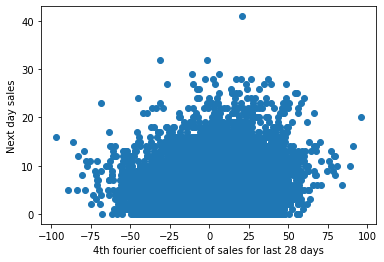

In [196]:
plt.scatter(features[0]['sales__fft_coefficient__attr_"real"__coeff_4'],targets[0])
plt.ylabel('Next day sales')
plt.xlabel('4th fourier coefficient of sales for last 28 days')
plt.show()

Visually, we can see that this doesn't really give us much information for forecasting the next days sales on its own. Instead of actually looking at the correlation coefficient alongside the p-value, the hypothesis test just takes the p-value, even if the correlation is really low. The way that the `kendalltau` function works is that it returns the p-value for the null hypothesis that $\tau$ = 0. Essentially, tsfresh is just keeping features where we *cannot* say that there is *no* correlation.

In [197]:
from scipy.stats import kendalltau
print(kendalltau(features[0]['sales__fft_coefficient__attr_"real"__coeff_4'], targets[0]))
print('p-value used by tsfresh:', target_real_feature_real_test(features[0]['sales__fft_coefficient__attr_"real"__coeff_4'], targets[0]))

KendalltauResult(correlation=0.051523269489373254, pvalue=0.0)
p-value used by tsfresh: 0.0


### Categorical Features

Another thing we can look at is if the feature selection methodology will be useful for filtering categorical features. Again, the methods in tsfresh only consider each variable individually; it does not consider interactions when assessing feature relevance. We'll demonstrate how tsfresh handles these using provided categorical features from the m5 data. PROBLEM: we can't pass un-encoded categorical variables into the hypothesis tests as they only accept numeric values.

In [12]:
df_rolled_ts = pd.read_hdf('data/interim/rolled_ts_WI_1_HOUSEHOLD_1.h5')

In [13]:
df_rolled_ts.set_index('id', inplace=True)
df_rolled_ts['last_date'] = [x[1] for x in df_rolled_ts.index.values]
df_rolled_last = df_rolled_ts[df_rolled_ts['date'] == df_rolled_ts['last_date']]
df_rolled_last = df_rolled_last.drop(df_rolled_last.index[drop])
df_rolled_last['prod_id'] = df_rolled_last.index.map(lambda x: x[0])
X_cat = ( df_rolled_last.merge(cat_features, how='left', on='prod_id')
         .set_index(X.index)
         .drop(columns=['date','sales','prod_id','last_date']) ) 

In [26]:
# these vars are already encoded
X_cal = (df_rolled_last.merge(calendar, on='date', how='left')
         .set_index(X.index)
         .assign(event=lambda x: -pd.isna(x.event_name_1))
         .drop(columns=['last_date','prod_id','d','snap_CA','snap_TX','event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','date','weekday']))

Try with one-hot encoding, target encoding and leave-one-out encoding.

In [15]:
import category_encoders as ce
te = ce.TargetEncoder()

In [17]:
X_cat_oh = pd.get_dummies(X_cat)
X_cat_te = te.fit_transform(X_cat, y)

/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [76]:
print('One-hot encoding')
print('Number of features before filtering:', X_cat_oh.shape[1])
X_cat_oh_filt = select_features(X_cat_oh, y)
print('Number of features after filtering:', X_cat_oh_filt.shape[1])

One-hot encoding
Number of features before filtering: 535
Number of features after filtering: 505


In [83]:
X_cat.item_id.nunique()

532

In [96]:
X_cat_oh_filt.columns.str.contains('dept').any() or X_cat_oh_filt.columns.str.contains('store').any() or X_cat_oh_filt.columns.str.contains('cat').any()

False

In [18]:
print('Target encoding')
print('Number of features before filtering:', X_cat_te.shape[1])
X_cat_te_filt = select_features(X_cat_te, y)
print('Number of features after filtering:', X_cat_te_filt.shape[1])

Target encoding
Number of features before filtering: 4
Number of features after filtering: 1


In [82]:
print(X_cat_te_filt.columns.values)

['item_id']


Text(0, 0.5, 'Next day sales')

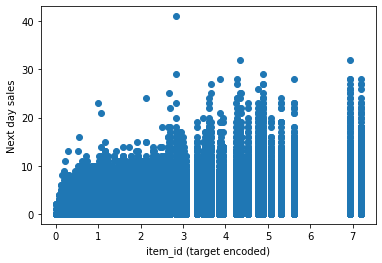

In [79]:
plt.scatter(X_cat_te_filt, y)
plt.xlabel('item_id (target encoded)')
plt.ylabel('Next day sales')

We can see that this does what we would have expected. Since we're only using data from one department in one store, the features `dept_id`, `cat_id` and `store_id` would be the same for every observation and therefore irrelevant. The only relevant categorical variable in this case is `item_id` and we can see the relationship between the feature and the next day sales. This is true for both the one-hot and target encoding methods. One-hot encoding restricts the feature more than target encoding when feature selection is conducted, returning only 505 features while there were 532 features generated from the `item_id` column. Let's take a look at the relevance table for this set.

In [97]:
rel_cat = calculate_relevance_table(X_cat_oh, y)
rel_cat.iloc[500:510, :]

,feature,type,p_value,relevant
feature,,,,
item_id_HOUSEHOLD_1_529,item_id_HOUSEHOLD_1_529,binary,0.005341,True
item_id_HOUSEHOLD_1_208,item_id_HOUSEHOLD_1_208,binary,0.005419,True
item_id_HOUSEHOLD_1_171,item_id_HOUSEHOLD_1_171,binary,0.006841,True
item_id_HOUSEHOLD_1_076,item_id_HOUSEHOLD_1_076,binary,0.006886,True
item_id_HOUSEHOLD_1_455,item_id_HOUSEHOLD_1_455,binary,0.006886,True
item_id_HOUSEHOLD_1_522,item_id_HOUSEHOLD_1_522,binary,0.007994,False
item_id_HOUSEHOLD_1_093,item_id_HOUSEHOLD_1_093,binary,0.011185,False
item_id_HOUSEHOLD_1_289,item_id_HOUSEHOLD_1_289,binary,0.012298,False
item_id_HOUSEHOLD_1_266,item_id_HOUSEHOLD_1_266,binary,0.014183,False


In [31]:
rel_cal = calculate_relevance_table(X_cal, y)
X_cal_filt = select_features(X_cal,y)
rel_cal

,feature,type,p_value,relevant
feature,,,,
sales,sales,real,0.000000e+00,True
year,year,real,5.564552e-254,True
wm_yr_wk,wm_yr_wk,real,2.395193e-245,True
wday,wday,real,1.254007e-131,True
month,month,real,9.253020e-35,True
event,event,binary,2.425586e-09,True
snap_WI,snap_WI,binary,9.888027e-01,False


Text(0.5, 1.0, 'Relevant Feature')

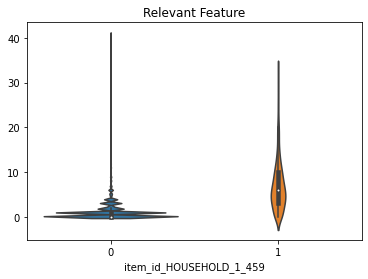

In [111]:
sns.violinplot(x=X_cat_oh['item_id_HOUSEHOLD_1_459'], y=y)
plt.title('Relevant Feature')

Text(0.5, 1.0, 'Irrelevant Feature')

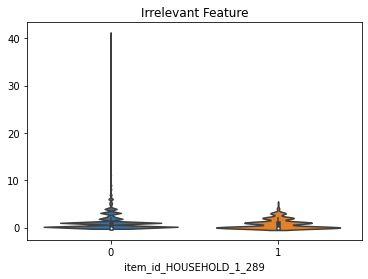

In [112]:
sns.violinplot(x=X_cat_oh['item_id_HOUSEHOLD_1_289'], y=y)
plt.title('Irrelevant Feature')

We can see from the distribution plots that the highly relevant feature shows very different distributions for the target variable when conditionally modeled on the feature, while for the irrelevant feature the distributions are much more similar. The way that tsfresh uses hypothesis tests when at least one of the feature or target are binary, results in more meaningful feature selection.

## Regression (Forecasting) <a name="reg"></a>
Now, we'll see how a LightGBM regression tree fares using these features.

In [237]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

In [207]:
full_dms = []
for i, dm in enumerate(features_filtered):
    X = dm.merge(X_cat_te_filt, left_index=True, right_index=True)
    X = X.merge(X_cal_filt, left_index=True, right_index=True)
    X['horizon'] = horizons[i]
    full_dms.append(X)
    del X

In [221]:
X = pd.concat(full_dms, axis=0)
X['horizon'] = X['horizon'].astype('category')
X.columns = X.columns.str.replace('"','')
y = pd.concat(targets, axis=0)

In [222]:
X_train, y_train = X[X.index.map(lambda x:x[1]) <= '2015-05-02'], y[y.index.map(lambda x:x[1]) <= '2015-05-02']
X_test, y_test = X[X.index.map(lambda x:x[1]) > '2015-05-02'], y[y.index.map(lambda x:x[1]) > '2015-05-02']

In [322]:
trn = lgb.Dataset(data=X_train, label=y_train)
val = lgb.Dataset(data=X_test, label=y_test)

In [224]:
params = {
    "objective": "tweedie"
}

In [323]:
def wape(y_true, y_pred):
    return np.sum(np.where(y_true > 0, np.abs(y_true - np.round(y_pred)), 0)) / np.sum(y_true)

def lgb_wape(y_pred, train_data):
    y_true = train_data.get_label()
    wape_val = wape(y_true, y_pred)
    return "wape", wape_val, False

def bias(y_true, y_pred):
    return (np.sum(np.round(y_pred)) - np.sum(y_true))/np.sum(y_true)

def lgb_bias(y_pred, train_data):
    y_true = train_data.get_label()
    bias_val = bias(y_true, y_pred)
    return "bias", bias_val, False

def lgb_biobj(y_pred, train_data):
    y_true = train_data.get_label()
    bias_val = bias(y_true, y_pred)
    bias_contrib_val = 1000*((bias_val-0.2)**6)
    wape_val = wape(y_true, y_pred)
    return "biobj", wape_val + bias_contrib_val, False

In [225]:
bst = lgb.train(params, train_set=trn, valid_sets=[val],
                feval=lambda *xs: [lgb_wape(*xs), lgb_bias(*xs), lgb_biobj(*xs)],
                num_boost_round=200,
                early_stopping_rounds=200,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5292
[LightGBM] [Info] Number of data points in the train set: 582540, number of used features: 31


/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score -0.083665
Training until validation scores don't improve for 200 rounds
[50]	valid_0's tweedie: 3.68861	valid_0's wape: 0.500182	valid_0's bias: -0.0864609	valid_0's biobj: 1.05276
[100]	valid_0's tweedie: 3.69032	valid_0's wape: 0.501078	valid_0's bias: -0.088284	valid_0's biobj: 1.07509
[150]	valid_0's tweedie: 3.69366	valid_0's wape: 0.504019	valid_0's bias: -0.093457	valid_0's biobj: 1.14267
[200]	valid_0's tweedie: 3.70051	valid_0's wape: 0.511489	valid_0's bias: -0.112226	valid_0's biobj: 1.43793
Did not meet early stopping. Best iteration is:
[49]	valid_0's tweedie: 3.68852	valid_0's wape: 0.500125	valid_0's bias: -0.0869008	valid_0's biobj: 1.05781


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

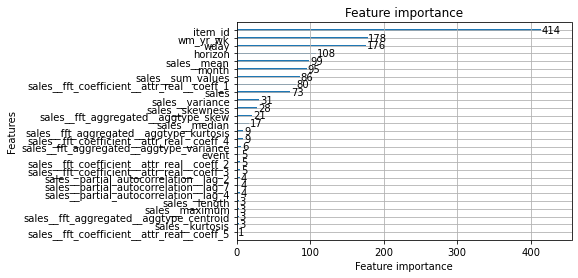

In [226]:
lgb.plot_importance(bst)

We get a WAPE of 50% and a BIAS of -9%. The best features are `item_id` (expected), followed by some date features, including the forecast horizon.

In [229]:
full_ts = []
for i, dm in enumerate(features_filtered):
    dm['horizon'] = horizons[i]
    full_ts.append(dm)

X_ts = pd.concat(full_ts, axis=0)
X_ts['horizon'] = X_ts['horizon'].astype('category')
X_ts.columns = X_ts.columns.str.replace('"','')

# Using ONLY tsfresh features
X_train, y_train = X_ts[X_ts.index.map(lambda x:x[1]) <= '2015-05-02'], y[y.index.map(lambda x:x[1]) <= '2015-05-02']
X_test, y_test = X_ts[X_ts.index.map(lambda x:x[1]) > '2015-05-02'], y[y.index.map(lambda x:x[1]) > '2015-05-02']

# just one forecast horizon - next day of sales
trn_ts = lgb.Dataset(data=X_train, label=y_train)
val_ts = lgb.Dataset(data=X_test, label=y_test)
bst_ts = lgb.train(params, train_set=trn_ts, valid_sets=[val_ts],
                   feval=lambda *xs: [lgb_wape(*xs), lgb_bias(*xs), lgb_biobj(*xs)],
                   num_boost_round=200,
                   early_stopping_rounds=200,
                   verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4932
[LightGBM] [Info] Number of data points in the train set: 582540, number of used features: 24


/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score -0.083665
Training until validation scores don't improve for 200 rounds
[50]	valid_0's tweedie: 3.71193	valid_0's wape: 0.498618	valid_0's bias: -0.0415873	valid_0's biobj: 0.697431
[100]	valid_0's tweedie: 3.71171	valid_0's wape: 0.498412	valid_0's bias: -0.0373365	valid_0's biobj: 0.677138
[150]	valid_0's tweedie: 3.71225	valid_0's wape: 0.498743	valid_0's bias: -0.0374131	valid_0's biobj: 0.677815
[200]	valid_0's tweedie: 3.71287	valid_0's wape: 0.499479	valid_0's bias: -0.039435	valid_0's biobj: 0.687899
Did not meet early stopping. Best iteration is:
[64]	valid_0's tweedie: 3.71163	valid_0's wape: 0.498411	valid_0's bias: -0.0391792	valid_0's biobj: 0.685626


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

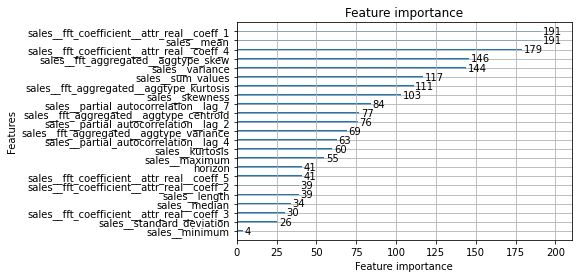

In [230]:
lgb.plot_importance(bst_ts)

The model using only tsfresh features somehow works even better than the one with categorical features. We get a WAPE of 50% and a BIAS of -4%. The best features are the 1st fourier coefficient and the mean of the last 28 days of sales. tsfresh kinda works dude.

## Classification <a name="class"></a>
An interesting approach in the M5 competition was to build a classifier to predict whether there would be no sales at a certain forecast horizon [[2]](#178th). This was then paired with a regressor to produce forecasts. We can try this and see if we get a different set of features that are good predictors of 0 days. We'll set the target to `True` when there are sales and `False` when there are no sales.


In [305]:
X = pd.read_hdf('data/interim/restricted_features_HOUSEHOLD_1_WI_1.h5')

features = []
targets = []
horizons = [1, 4, 7]

for horizon in horizons:
    y = df_melted.groupby("id").apply(lambda x: x.set_index("date")["sales"].shift(-horizon)).T.unstack()
    y = y.loc[(slice(None), slice('2014-05-03', '2016-04-25'))]
    drop = np.where(np.isnan(y.values))[0]
    y = y.drop(y.index[drop])
    y = y.apply(lambda x: False if (x==0) else True)
    X_h = X.drop(X.index[drop])
    targets.append(y)
    features.append(X_h)

In [307]:
features_filtered = []

# first run feature selection to demonstrate the filtering process
for i, dm in enumerate(features):
    print(F'\nFeature selection for horizon {horizons[i]}')
    print('Number of features before selection:', dm.shape[1])
    dm_filt = select_features(dm, targets[i], fdr_level=0.05)
    print('Number of features after selection:', dm_filt.shape[1])
    features_filtered.append(dm_filt)


Feature selection for horizon 1
Number of features before selection: 23
Number of features after selection: 23

Feature selection for horizon 4
Number of features before selection: 23
Number of features after selection: 22

Feature selection for horizon 7
Number of features before selection: 23
Number of features after selection: 22


In [308]:
full_dms = []
for i, dm in enumerate(features_filtered):
    X = dm.merge(X_cat_te_filt, left_index=True, right_index=True)
    X = X.merge(X_cal_filt, left_index=True, right_index=True)
    X['horizon'] = horizons[i]
    full_dms.append(X)
    del X
X = pd.concat(full_dms, axis=0)
X['horizon'] = X['horizon'].astype('category')
X.columns = X.columns.str.replace('"','')
X = X.drop(columns=['sales__fft_coefficient__attr_real__coeff_1','sales__fft_coefficient__attr_real__coeff_2'])
y = pd.concat(targets, axis=0)

In [310]:
X_train, y_train = X[X.index.map(lambda x:x[1]) <= '2015-05-02'], y[y.index.map(lambda x:x[1]) <= '2015-05-02']
X_test, y_test = X[X.index.map(lambda x:x[1]) > '2015-05-02'], y[y.index.map(lambda x:x[1]) > '2015-05-02']

In [312]:
trn = lgb.Dataset(data=X_train, label=y_train)
val = lgb.Dataset(data=X_test, label=y_test)

In [313]:
params = {'objective':'binary',
         'metric': 'auc'}
clf = lgb.train(params, train_set=trn, valid_sets=[val],
                num_boost_round=200,
                early_stopping_rounds=200,
                verbose_eval=50)

[LightGBM] [Info] Number of positive: 246047, number of negative: 336493
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4782
[LightGBM] [Info] Number of data points in the train set: 582540, number of used features: 29


/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/kartikeyvyas/miniconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422369 -> initscore=-0.313055
[LightGBM] [Info] Start training from score -0.313055
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.799166
[100]	valid_0's auc: 0.798955
[150]	valid_0's auc: 0.798473
[200]	valid_0's auc: 0.797951
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.799323


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

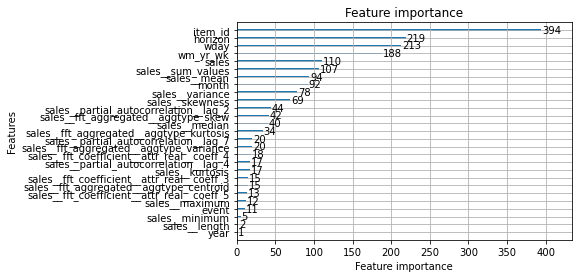

In [325]:
lgb.plot_importance(clf)

In [314]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [315]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [316]:
roc_auc_score(y_test, y_pred)

0.710247674235259

Ok so using AUC as a metric, LightGBM actually does a better job than a random forest and runs WAY faster. An AUC of 0.8 is okay, but this shows the feasibility of using tsfresh features for classification. I think the challenge here is that the past *N* days of sales aren't necessarily the best predictor of whether we will have *some* sales at 1,4 and 7 day horizons, but this idea can definitely be refined and explored further for the RETAILER's project.

## References <a name="refs"></a>

[1] <a name="fresh"></a>Distributed and parallel time series feature extraction for industrial big data applications. https://arxiv.org/pdf/1610.07717v3.pdf  
[2] <a name="178th"></a>Recursive Model with Regression & Classification [178th]. Kaggle, M5 Forecasting - Accuracy. https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163372